In [5]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Data available in 8 tables
# 1. customers --> PK:customer_id FK:customer_zip_code_prefix
# 2. geolocation --> PK:geolocation_zip_code_prefix
# 3. order_items --> PK:order_id FK:product_id FK:seller_id
# 4. payments --> PK:order_id
# 5. reviews --> PK:order_id
# 6. orders --> PK:order_id FK:customer_id
# 7. products --> PK:product_id
# 8. sellers --> PK:seller_id FK:seller_zip_code_prefix

##Exploratory Analysis 

Data type of columns in a table 

In [22]:
%%bigquery --project bold-rampart-365506
SELECT
  column_name, data_type
from
  TargetSQL.INFORMATION_SCHEMA.COLUMNS
limit
  5

# Data type of columns of all the tables in the dataset

Query is running:   0%|          |

Downloading:   0%|          |

,column_name,data_type
0,order_id,STRING
1,order_item_id,INT64
2,product_id,STRING
3,seller_id,STRING
4,shipping_limit_date,TIMESTAMP


Time period for which the data is given

In [8]:
%%bigquery --project bold-rampart-365506
SELECT 
  min(order_purchase_timestamp) as order_time_min,
  max(order_delivered_customer_date) as order_time_max
from 
  TargetSQL.orders

# Insights
# Data in the dataset is from September 2016 to October 2018

Query is running:   0%|          |

Downloading:   0%|          |

,order_time_min,order_time_max
0,2016-09-04 21:15:19+00:00,2018-10-17 13:22:46+00:00


States covered in the dataset

In [26]:
%%bigquery --project bold-rampart-365506 --verbose df_distinct_states
select distinct(state) from
(select distinct(customer_state) as state from TargetSQL.customers
UNION ALL
select distinct(geolocation_state) as state from TargetSQL.geolocation
UNION ALL
select distinct(seller_state) as state from TargetSQL.sellers)

Executing query with job ID: 6d3c1db7-d3fc-4bf2-9f05-b7c054aa5895
Query executing: 0.95s
Job ID 6d3c1db7-d3fc-4bf2-9f05-b7c054aa5895 successfully executed


Query is running:   0%|          |

Downloading:   0%|          |

In [27]:
distinct_states = pd.DataFrame(df_distinct_states)
states = distinct_states['state'].tolist()
print('States covered in the dataset:')
print('Total States:', len(states))
print(','.join(map(repr, states)))


States covered in the dataset:
Total States: 27
'AC','AM','BA','CE','DF','ES','GO','MA','MG','MS','MT','PA','PB','PE','PI','PR','RJ','RN','RO','RS','SC','SE','SP','TO','AL','RR','AP'


Cities covered in the dataset

In [28]:
%%bigquery --project bold-rampart-365506 --verbose df_distinct_cities
select distinct(city) from
(select distinct(customer_city) as city from TargetSQL.customers
UNION ALL
select distinct(geolocation_city) as city from TargetSQL.geolocation
UNION ALL
select distinct(seller_city) as city from TargetSQL.sellers)

Executing query with job ID: f6a12d64-c625-4a36-96fa-936ffa18620a
Query executing: 1.44s
Job ID f6a12d64-c625-4a36-96fa-936ffa18620a successfully executed


Query is running:   0%|          |

Downloading:   0%|          |

In [29]:
distinct_cities = pd.DataFrame(df_distinct_cities)
cities = distinct_cities['city'].tolist()
print('Cities covered in the dataset:')
print('Total Cities:', len(cities))
print(','.join(map(repr, cities)))

Cities covered in the dataset:
Total Cities: 8126
'rio branco','manaus','bahia','ipira','irece','ilheus','guanambi','salvador','eunapolis','barro alto','porto seguro','feira de santana','lauro de freitas',"arraial d'ajuda (porto seguro)",'caucaia','eusebio','mucambo','pacatuba','fortaleza','varzea alegre','juzeiro do norte','gama','brasilia','brasilia df','muqui','serra','viana','vitoria','colatina','cariacica','vila velha','afonso claudio','cariacica / es','domingos martins','cachoeiro de itapemirim','uruacu','formosa','goiania','jaragua','anapolis','luziania','morrinhos','rio verde','piracanjuba','abadia de goias','aparecida de goiania','santa terezinha de goias','sao luis','uba','ibia','araxa','betim','arinos','centro','itauna','muriae','passos','prados','sabara','vicosa','alfenas','claudio','extrema','formiga','ibirite','itabira','janauba','lambari','timoteo','uberaba','andradas','araguari','baependi','campanha','contagem','guanhaes','ilicinea','ipatinga','oliveira','varginha','bar

##In-depth Exploration

Is there a growing trend on e-commerce in Brazil? How can we describe a complete scenario? 

Can we see some seasonality with peaks at specific months?

Assumption: Dataset contains all e-commerce orders and none from retail store 

In [31]:
%%bigquery --project bold-rampart-365506 --verbose df_orders_per_month
with
  month_on_month_orders 
as
  (select
    parse_date('%Y-%m',concat(extract(year from order_purchase_timestamp),'-',extract(month from order_purchase_timestamp))) as month,
    count(*) as orders_per_month
  from
    TargetSQL.orders
  group by
    month
  order by
    month
  )

select
  month,
  orders_per_month,
  round(100 * (orders_per_month - lag(orders_per_month) over (order by month))/(lag(orders_per_month) over (order by month)), 2) || '%' as month_on_month_growth
from
  month_on_month_orders as momo
order by
  month

Executing query with job ID: 84aa0bca-bed8-4bb0-bad4-52ee1d4ce5ee
Query executing: 2.72s
Job ID 84aa0bca-bed8-4bb0-bad4-52ee1d4ce5ee successfully executed


Query is running:   0%|          |

Downloading:   0%|          |

In [32]:
df_orders_per_month[:5]

,month,orders_per_month,month_on_month_growth
0,2016-09-01,4,None
1,2016-10-01,324,8000%
2,2016-12-01,1,-99.69%
3,2017-01-01,800,79900%
4,2017-02-01,1780,122.5%


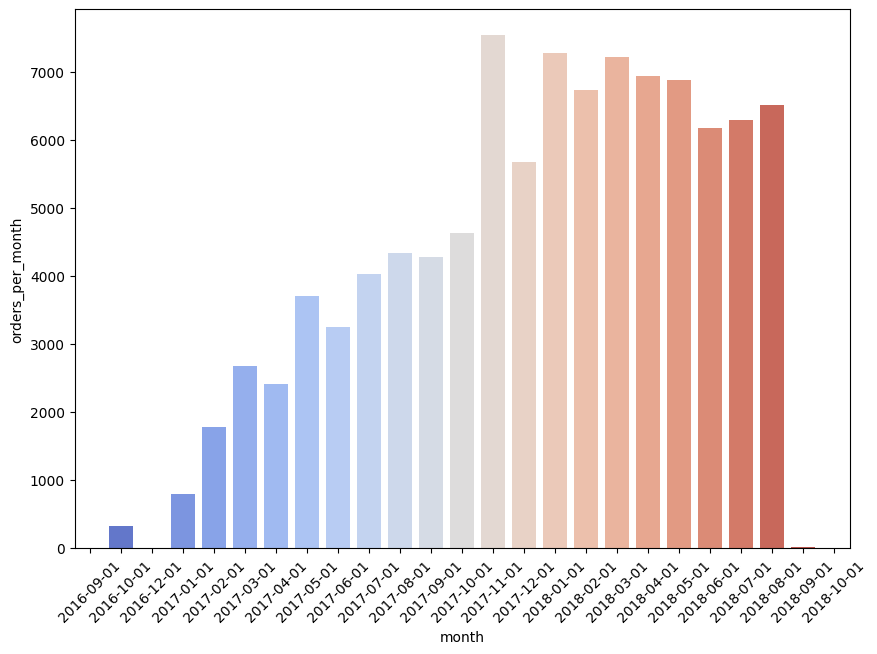

In [34]:
fig = plt.figure() 
fig.set_size_inches(10, 7)
sns.barplot(data = df_orders_per_month, x = 'month', y = 'orders_per_month', palette = 'coolwarm')
plt.xticks(rotation = 45)

plt.show()

# Insights
# As per the data provided, there definitely seems to be a growing trend in the e-commerce orders
# Certain spike can be observed in January month as compared to the December month of the previous year

What time do Brazilian customers tend to buy (Dawn, Morning, Afternoon or Night)?

In [ ]:
%%bigquery --project bold-rampart-365506 df_orders_distribution_daytime
select
  case 
    when extract(hour from order_purchase_timestamp) between 4 and 6.9 then 'Dawn'
    when extract(hour from order_purchase_timestamp) between 7 and 11.9 then 'Morning'
    when extract(hour from order_purchase_timestamp) between 12 and 15.9 then 'Afternoon'
    when extract(hour from order_purchase_timestamp) between 16 and 19.9 then 'Evening'
    when extract(hour from order_purchase_timestamp) between 20 and 24 then 'Night'
    when extract(hour from order_purchase_timestamp) between 0 and 3.9 then 'Night'
    else 'Not Available'
  end as time_of_the_day,
  count(*) as Total_orders
from TargetSQL.orders
group by time_of_the_day
order by total_orders desc

In [ ]:
df_orders_distribution_daytime

,time_of_the_day,Total_orders
0,Night,26695
1,Afternoon,25536
2,Evening,24576
3,Morning,21738
4,Dawn,896


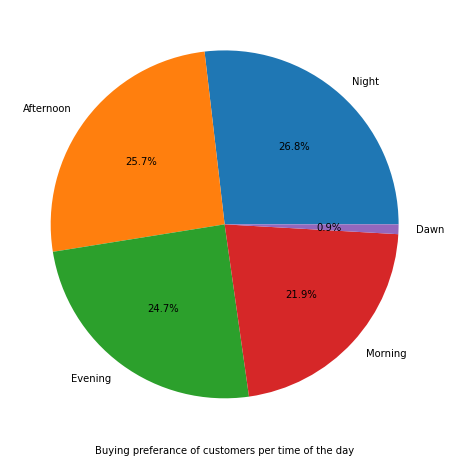

In [ ]:
fig = plt.figure() 
fig.set_size_inches(16, 8)
plt.pie(df_orders_distribution_daytime['Total_orders'], labels = df_orders_distribution_daytime['time_of_the_day'], autopct='%.1f%%')
plt.xlabel('Buying preferance of customers per time of the day')

plt.show()


# Insights
# Distribution of orders placed throughout the day is quite uniform except for dawn. Very few orders are placed at dawn.

##Evolution of E-commerce orders in the Brazil region

Get month on month orders by states

In [ ]:
%%bigquery --project bold-rampart-365506
with 
  monthly_orders_by_states 
as
  (
select
  x.customer_state as state,
  parse_date('%Y-%m',concat(extract(year from order_purchase_timestamp),'-',extract(month from order_purchase_timestamp))) as month,
  count(*) as count,
from
  TargetSQL.orders
LEFT JOIN
  (select 
    customers.customer_id,
    customer_state
  from
    TargetSQL.customers
  ) x
ON
  orders.customer_id = x.customer_id
GROUP BY
  customer_state, month
ORDER BY
  customer_state, month
  )
  
select
  mos.state,
  mos.month,
  mos.count as orders_per_month,
  count - lag(count) over (partition by state order by month) as month_over_month_orders,
  round(100 * (count - lag(count) over (partition by state order by month)) / (lag(count) over (partition by state order by month)),2) || '%' as growth
from
  monthly_orders_by_states as mos

,state,month,orders_per_month,month_over_month_orders,growth
0,SE,2016-10-01,3,NaN,None
1,SE,2017-01-01,4,1.0,33.33%
2,SE,2017-02-01,12,8.0,200%
3,SE,2017-03-01,25,13.0,108.33%
4,SE,2017-04-01,13,-12.0,-48%
...,...,...,...,...,...
560,RR,2018-03-01,6,1.0,20%
561,RR,2018-04-01,2,-4.0,-66.67%
562,RR,2018-05-01,1,-1.0,-50%
563,RR,2018-06-01,5,4.0,400%


Get month on month orders by region

Assumption: region means city

In [ ]:
%%bigquery --project bold-rampart-365506
with
  monthly_orders_by_cities
as
  (
select
  x.customer_city as city,
  parse_date('%Y-%m',concat(extract(year from order_purchase_timestamp),'-',extract(month from order_purchase_timestamp))) as month,
  count(*) as count,
from
  TargetSQL.orders
LEFT JOIN
  (select 
    customers.customer_id,
    customer_city
  from
    TargetSQL.customers
  ) x
ON
  orders.customer_id = x.customer_id
GROUP BY
  customer_city, month
ORDER BY
  customer_city, month
  )

select
  moc.city,
  moc.month,
  moc.count as orders_per_month,
  count - lag(count) over (partition by city order by month) as month_over_month_orders,
  round(100 * (count - lag(count) over (partition by city order by month)) / (lag(count) over (partition by city order by month)),2) || '%' as growth
from
  monthly_orders_by_cities as moc
order by
  city, month

,city,month,orders_per_month,month_over_month_orders,growth
0,abadia dos dourados,2017-09-01,1,NaN,None
1,abadia dos dourados,2018-03-01,1,0.0,0%
2,abadia dos dourados,2018-07-01,1,0.0,0%
3,abadiania,2018-01-01,1,NaN,None
4,abaete,2017-02-01,1,NaN,None
...,...,...,...,...,...
21511,ze doca,2017-11-01,1,0.0,0%
21512,ze doca,2017-12-01,1,0.0,0%
21513,ze doca,2018-02-01,2,1.0,100%
21514,zortea,2017-06-01,1,NaN,None


How are customers distributed in Brazil - statewise

In [ ]:
%%bigquery --project bold-rampart-365506 df_customer_distribution_states
select
  customer_state as state,
  count(distinct(customer_unique_id)) as count_of_users
from
  TargetSQL.customers
group by
  customer_state

In [ ]:
df_customer_distribution_states

,state,count_of_users
0,RN,474
1,CE,1313
2,RS,5277
3,SC,3534
4,SP,40302
5,MG,11259
6,BA,3277
7,RJ,12384
8,GO,1952
9,MA,726


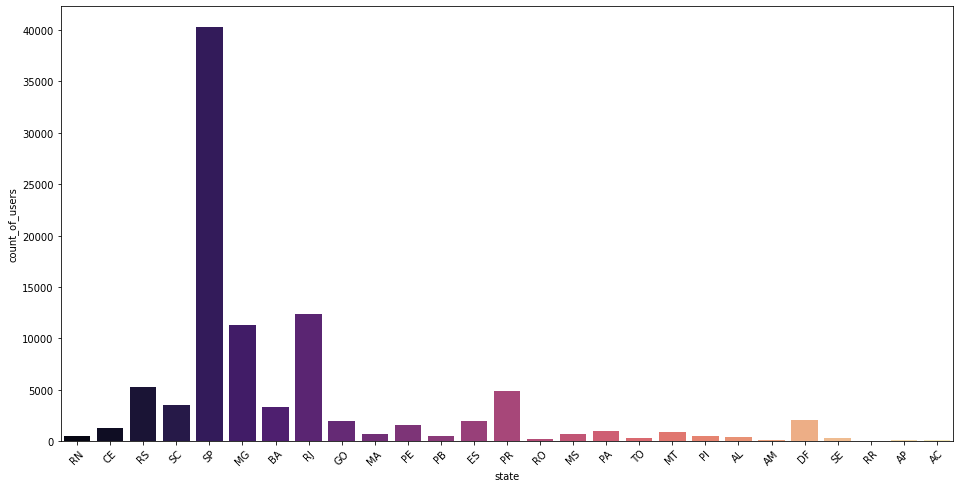

In [ ]:
fig = plt.figure() 
fig.set_size_inches(16, 8)
sns.barplot(data = df_customer_distribution_states, x = 'state', y = 'count_of_users', palette = 'magma')
plt.xticks(rotation = 45)

plt.show()

# Insights
# States having highest number of customers --> SP, RJ, MG, RS, PR
# States having lowest number of customers --> RR, AP, AC, AM, RO

How are customers distributed in Brazil - citywise

In [ ]:
%%bigquery --project bold-rampart-365506 df_customer_distribution_cities
select
  customer_city as city,
  count(distinct(customer_unique_id)) as count_of_users
from
  TargetSQL.customers
group by
  customer_city
order by
  count_of_users desc

In [ ]:
df_customer_distribution_cities

,city,count_of_users
0,sao paulo,14984
1,rio de janeiro,6620
2,belo horizonte,2672
3,brasilia,2069
4,curitiba,1465
...,...,...
4114,santo antonio do rio abaixo,1
4115,polo petroquimico de triunfo,1
4116,santo antonio do aventureiro,1
4117,sao goncalo do rio das pedras,1


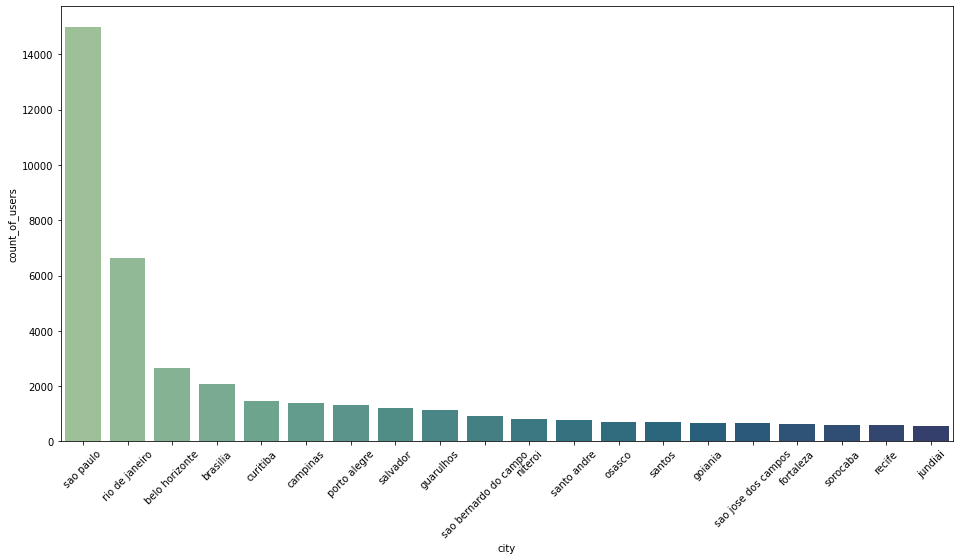

In [ ]:
fig = plt.figure() 
fig.set_size_inches(16, 8)
sns.barplot(data = df_customer_distribution_cities[:20], x = 'city', y = 'count_of_users', palette = 'crest')
plt.xticks(rotation = 45)

plt.show()

# Insights
# Cities having highest number of customers --> sao paulo, rio de janeiro, belo horizonte, brasilia, curitiba

##Impact on Economy

Get % increase in cost of orders from 2017 to 2018 (include months between Jan to Aug only)

In [ ]:
%%bigquery --project bold-rampart-365506 df_inc_cost_of_orders
with 
  orders_cost_2017_2018 
as
  (select
    parse_date('%Y-%m',concat(extract(year from order_purchase_timestamp),'-',extract(month from order_purchase_timestamp))) as month,
    sum(x.payment_value) as cost_of_orders_per_month
  from
    TargetSQL.orders
  LEFT JOIN
  (select
    payments.order_id,
    payment_value
  from
    TargetSQL.payments
  ) x
  ON
    orders.order_id = x.order_id
  GROUP BY
    month
  ORDER BY
    month
  ),

  month_cost_of_orders 
as
  (select 
    * 
  from 
    orders_cost_2017_2018
  where
    month between '2017-01-01' and '2017-08-01'
  or
    month between '2018-01-01' and '2018-08-01'
  )

select
  *,
  round(100 * (cost_of_orders_per_month - lag(cost_of_orders_per_month,8) over (order by month)) / (lag(cost_of_orders_per_month,8) over (order by month)),2) || '%' as percentage_increase
from
  month_cost_of_orders
order by
  month

In [ ]:
df_inc_cost_of_orders

,month,cost_of_orders_per_month,percentage_increase
0,2017-01-01,138488.04,None
1,2017-02-01,291908.01,None
2,2017-03-01,449863.60,None
3,2017-04-01,417788.03,None
4,2017-05-01,592918.82,None
5,2017-06-01,511276.38,None
6,2017-07-01,592382.92,None
7,2017-08-01,674396.32,None
8,2018-01-01,1115004.18,705.13%
9,2018-02-01,992463.34,239.99%


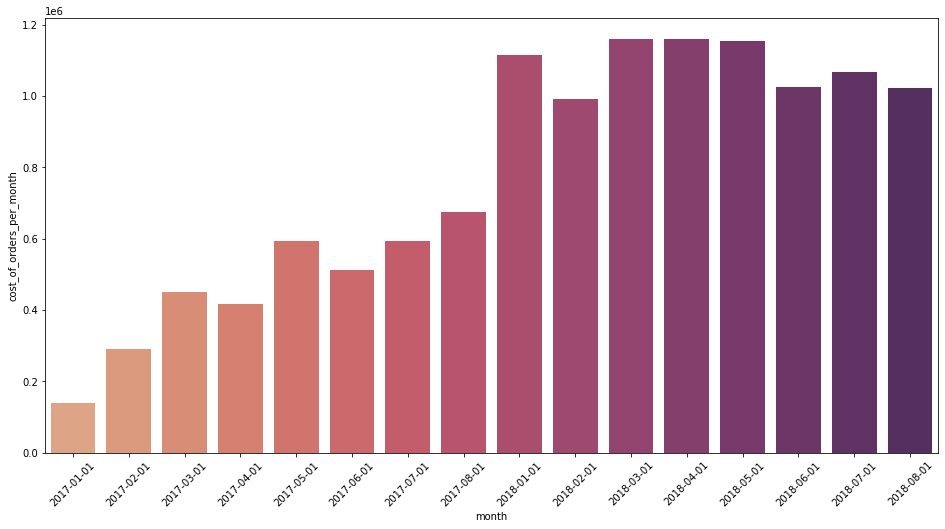

In [ ]:
fig = plt.figure() 
fig.set_size_inches(16, 8)
sns.barplot(data = df_inc_cost_of_orders, x = 'month', y = 'cost_of_orders_per_month', palette = 'flare')
plt.xticks(rotation = 45)

plt.show()

# Insights
# There has been considerable growth in cost of orders from 2017 to 2018 in the months of January, February, March and April

Mean & Sum of price and freight value by customer state

In [ ]:
%%bigquery --project bold-rampart-365506 df_price_freight_value_state
with
  price_freight_value_by_customer_state
as
  (
  select
    y.customer_state,
    price,
    freight_value
  from
    TargetSQL.order_items
  LEFT JOIN
    (select
      orders.order_id,
      orders.customer_id
    from
      TargetSQL.orders
    ) x
  ON
    order_items.order_id = x.order_id
  LEFT JOIN
    (select
      customers.customer_id,
      customer_state
    from
      TargetSQL.customers
    ) y
  ON x.customer_id = y.customer_id
  )

select
  pfcs.customer_state as states,
  round(avg(price),2) as mean_price,
  round(sum(price)/1000,2) as sum_price_in_thousands,
  round(avg(freight_value),2) as mean_freight_value,
  round(sum(freight_value),2) as sum_freight_value
from
  price_freight_value_by_customer_state pfcs
group by
  states
order by
  sum_freight_value desc

In [ ]:
df_price_freight_value_state

,states,mean_price,sum_price_in_thousands,mean_freight_value,sum_freight_value
0,SP,109.65,5202.96,15.15,718723.07
1,RJ,125.12,1824.09,20.96,305589.31
2,MG,120.75,1585.31,20.63,270853.46
3,RS,120.34,750.30,21.74,135522.74
4,PR,119.00,683.08,20.53,117851.68
5,BA,134.60,511.35,26.36,100156.68
6,SC,124.65,520.55,21.47,89660.26
7,PE,145.51,262.79,32.92,59449.66
8,GO,126.27,294.59,22.77,53114.98
9,DF,125.77,302.60,21.04,50625.50


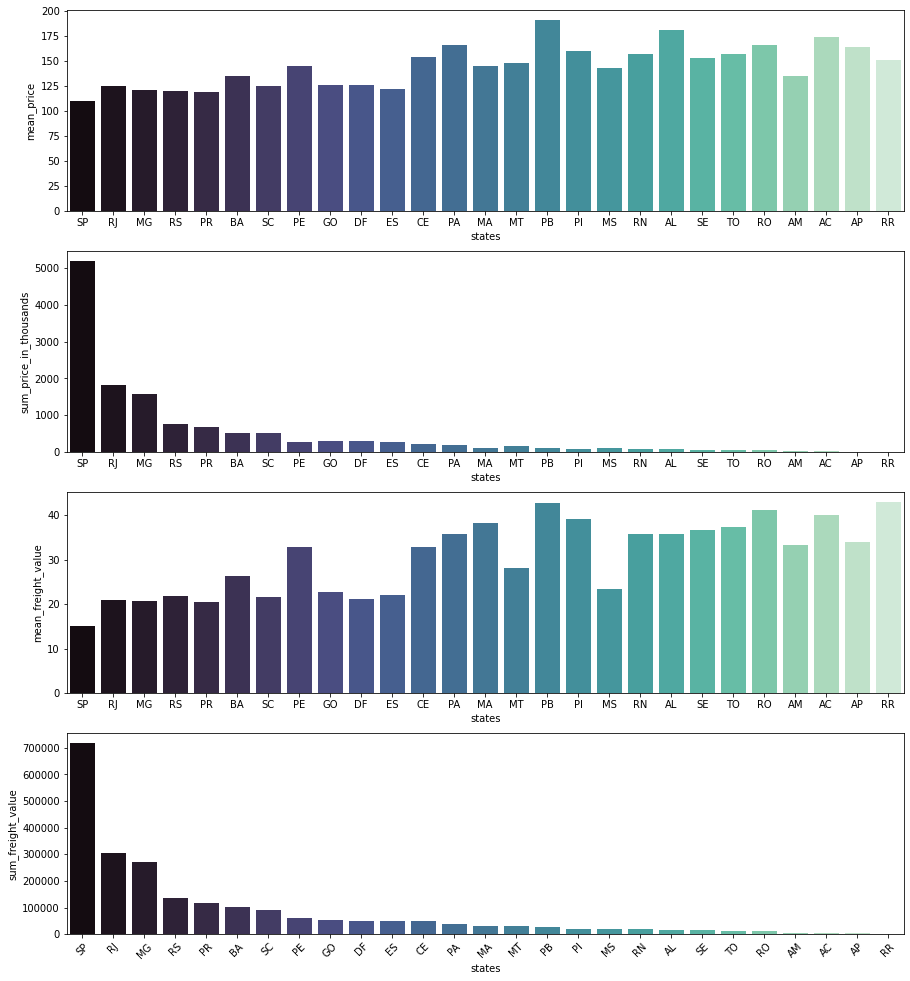

In [ ]:
fig, ax = plt.subplots(4, 1, figsize = (15,17))	 
sns.barplot(data = df_price_freight_value_state, x = 'states', y = 'mean_price', palette = 'mako', ax = ax[0])
sns.barplot(data = df_price_freight_value_state, x = 'states', y = 'sum_price_in_thousands', palette = 'mako', ax = ax[1])
sns.barplot(data = df_price_freight_value_state, x = 'states', y = 'mean_freight_value', palette = 'mako', ax = ax[2])
sns.barplot(data = df_price_freight_value_state, x = 'states', y = 'sum_freight_value', palette = 'mako', ax = ax[3])
plt.xticks(rotation = 45)

plt.show()


# Insights
# Top 5 states having highest mean price of products ordered --> PB, AL, AC, RO, PA
# Top 5 states having lowest mean price of products ordered --> SP, PR, RS, MG, ES
# Top 5 states creating maximum revenue --> SP, RJ, MG, RS, PR
# Top 5 states creating least revenue --> RR, AP, AC, AM, RO
# Top 5 states where freight is most expensive --> RR, PB, RO, AC, PI
# Top 5 states where freight is least expensive --> SP, PR, MG, RJ, DF
# Top 5 states which spent the most on freight --> SP, RJ, MG, RS, PR
# Top 5 states which spent the least on freight --> RR, AP, AC, AM, RO

##Analysis on sales, freight and delivery time

In [ ]:
%%bigquery --project bold-rampart-365506 df_sales_freight_delivery
select
  x.customer_state,
  round(avg(y.freight_value),2) as average_freight_value,
  round(avg(TIMESTAMP_DIFF(order_delivered_customer_date, order_purchase_timestamp, day)),2) as average_time_to_delivery_in_days,
  round(avg(TIMESTAMP_DIFF(order_delivered_customer_date, order_estimated_delivery_date, day)),2) as average_diff_estimated_delivery_in_days
from 
  TargetSQL.orders
LEFT JOIN
  (select
    customers.customer_id,
    customer_state
  from
    TargetSQL.customers) x
ON
  orders.customer_id = x.customer_id
LEFT JOIN
  (select
    order_items.order_id,
    freight_value
  from
    TargetSQL.order_items) y
ON
  orders.order_id = y.order_id
GROUP BY 
  x.customer_state
ORDER BY
  average_diff_estimated_delivery_in_days desc

In [ ]:
df_sales_freight_delivery

,customer_state,average_freight_value,average_time_to_delivery_in_days,average_diff_estimated_delivery_in_days
0,AL,35.84,23.99,-7.98
1,MA,38.26,21.20,-9.11
2,SE,36.65,20.98,-9.17
3,ES,22.06,15.19,-9.77
4,BA,26.36,18.77,-10.12
5,CE,32.71,20.54,-10.26
6,SP,15.15,8.26,-10.27
7,MS,23.37,15.11,-10.34
8,SC,21.47,14.52,-10.67
9,PI,39.15,18.93,-10.68


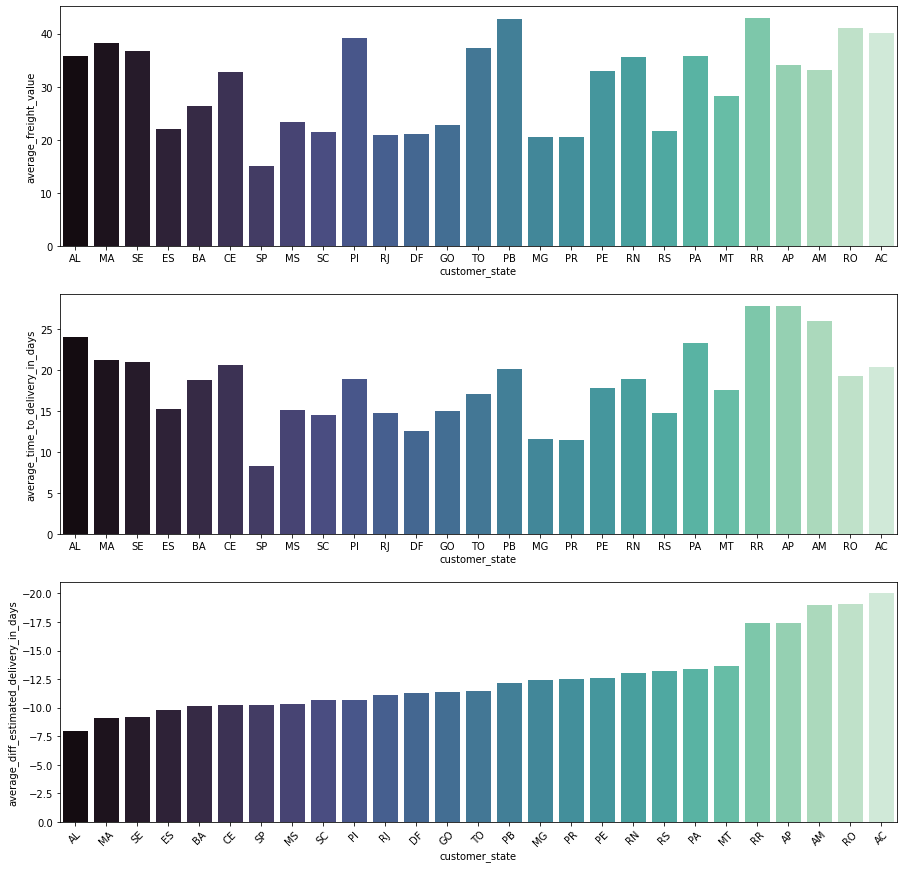

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (15,15))	 
# fig.set_size_inches(16, 8)
sns.barplot(data = df_sales_freight_delivery, x = 'customer_state', y = 'average_freight_value', palette = 'mako', ax = ax[0])
sns.barplot(data = df_sales_freight_delivery, x = 'customer_state', y = 'average_time_to_delivery_in_days', palette = 'mako', ax = ax[1])
sns.barplot(data = df_sales_freight_delivery, x = 'customer_state', y = 'average_diff_estimated_delivery_in_days', palette = 'mako', ax = ax[2])
ax[2].invert_yaxis()
plt.xticks(rotation = 45)

plt.show()


# Insights
# Top 5 states with highest average freight value --> RR, PB, RO, AC, PI
# Top 5 states with lowest average freight value --> SP, PR, MG, RJ, DF
# Top 5 states with highest average time to delivery --> RR, AP, AM, AL, PA
# Top 5 states with lowest average time to delivery --> SP, PR, MG, DF, SC
# Top 5 states wherein delivery is really fast --> AC, RO, AM, AP, RR
# Top 5 states wherein delivery is not so fast --> AL, MA, SE, ES, BA

##Payment type analysis

Month over Month count of orders for different payment types

In [ ]:
%%bigquery --project bold-rampart-365506
with
  mom_cnt_orders_payment_types
as
(
  select
    x.payment_type as payment_type,
    parse_date('%Y-%m',concat(extract(year from order_purchase_timestamp),'-',extract(month from order_purchase_timestamp))) as month,
    count(*) as count
  from
    TargetSQL.orders
  LEFT JOIN
    (select 
      payments.order_id,
      payment_type
    from
      TargetSQL.payments
    ) x
  ON
    orders.order_id = x.order_id
  GROUP BY
    payment_type, month
  ORDER BY
    payment_type, month
)

select
  mom_cnt.payment_type,
  mom_cnt.month,
  mom_cnt.count,
  count - lag(count) over (partition by payment_type order by month) as month_over_month_orders,
  round(100 * (count - lag(count) over (partition by payment_type order by month)) / (lag(count) over (partition by payment_type order by month)),2) || '%' as month_over_month_change
from
  mom_cnt_orders_payment_types mom_cnt
order by
  payment_type, month

,payment_type,month,count,month_over_month_orders,month_over_month_change
0,None,2016-09-01,1,NaN,None
1,UPI,2016-10-01,63,NaN,None
2,UPI,2017-01-01,197,134.0,212.7%
3,UPI,2017-02-01,398,201.0,102.03%
4,UPI,2017-03-01,590,192.0,48.24%
...,...,...,...,...,...
86,voucher,2018-06-01,324,0.0,0%
87,voucher,2018-07-01,281,-43.0,-13.27%
88,voucher,2018-08-01,295,14.0,4.98%
89,voucher,2018-09-01,15,-280.0,-94.92%


Distribution of payment installments and count of orders

In [ ]:
%%bigquery --project bold-rampart-365506 df_dist_payment_installments
select
  x.payment_installments,
  count(*) as count_of_orders,
  100*(count(*)/(select count(*) from TargetSQL.orders)) as perc_of_orders
from
  TargetSQL.orders
LEFT JOIN
  (select
    order_id,
    payment_installments
  from
    TargetSQL.payments) x
ON
  orders.order_id = x.order_id
GROUP BY
  payment_installments
ORDER BY
  count_of_orders desc

In [ ]:
df_dist_payment_installments

,payment_installments,count_of_orders,perc_of_orders
0,1.0,52546,52.841383
1,2.0,12413,12.482779
2,3.0,10461,10.519806
3,4.0,7098,7.137901
4,10.0,5328,5.357951
5,5.0,5239,5.268451
6,8.0,4268,4.291992
7,6.0,3920,3.942036
8,7.0,1626,1.635140
9,9.0,644,0.647620


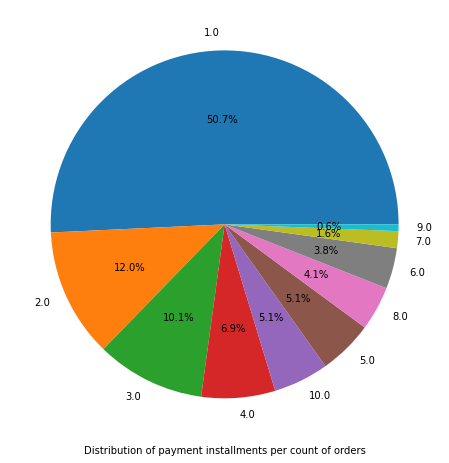

In [ ]:
fig = plt.figure() 
fig.set_size_inches(16, 8)
plt.xlabel('Distribution of payment installments per count of orders')
plt.pie(df_dist_payment_installments['count_of_orders'][:10], labels = df_dist_payment_installments['payment_installments'][:10], autopct='%.1f%%')

plt.show()

# Insights
# 75% of the customers tend to pay the order amount within 3 EMIs